# Construal shifting Experiment 1


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(lmtest)

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [4]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [5]:
def save_paper_input(input_name, input_str):
    filename = f"./inputs/{input_name}.tex"
    with open(filename, 'w') as file:
        file.write(input_str)
    print(f"Saved to {filename}:\n{input_str}")
    
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [6]:
import json
import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from msdm.algorithms import PolicyIteration
from msdm.core.distributions import SoftmaxDistribution

from construal_shifting.fastgridworld import GridWorld2 as GridWorld
from construal_shifting.utils import maze_code
from construal_shifting.construal import construal_level, construal_utility, construal_size, calculate_construal_dist, maze_construals
from construal_shifting import gridutils, sampsat

In [7]:
import matplotlib
font = {
    'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 12
}

matplotlib.rc('font', **font)

In [8]:
summary_df = pd.read_json('./data/summary_df.json')
test_trials = pd.read_json('./data/test_trial_stats.json')

In [9]:
test_trials['grid_idx'] = test_trials.grid_name.apply(lambda g: int(g.split('-')[0]))
test_trials['visited_notch'] = test_trials['notch_occupancy'] > 0
test_trials['log_initial_rt_milliseconds'] = np.log(test_trials['initial_rt_milliseconds'])
test_trials_summary = pd.merge(
    test_trials.groupby(['sessionId', 'condition_name'])[[
        'initial_rt_milliseconds',
        'log_initial_rt_milliseconds',
        'timesteps',
        'total_reward',
        'notch_occupancy'
    ]].mean(),
    test_trials.groupby(['sessionId', 'condition_name'])[[
        'visited_notch',
        'visited_critical_notch',
    ]].sum(),
    on=['sessionId', 'condition_name']
).reset_index()

In [10]:
test_trials_summary.groupby(['condition_name'])[
    ['visited_critical_notch', 'log_initial_rt_milliseconds', 'total_reward']
].agg(['mean', 'sem', 'count'])

visited_critical_notch                  \
                                 mean       sem count   
condition_name                                          
cccccccccccc                 4.877660  0.212277   188   
ffffffffffff                 7.074074  0.104627   189   

               log_initial_rt_milliseconds                 total_reward  \
                                      mean       sem count         mean   
condition_name                                                            
cccccccccccc                      7.714201  0.051510   188   -36.279255   
ffffffffffff                      7.846401  0.052583   189   -34.378968   

                                
                     sem count  
condition_name                  
cccccccccccc    1.557323   188  
ffffffffffff    1.969472   189

## Critical Notch Visit Analysis

In [11]:
%%R -i test_trials -o full_mod_crit_notch_summary,model_comp_crit_notch
test_trials$condition_name <- factor(
    test_trials$condition_name,
    levels=c('ffffffffffff', 'cccccccccccc')
)
contrasts(test_trials$condition_name) <- contr.sum(2)*.5
print(contrasts(test_trials$condition_name))

base_mod <- glm(
    visited_critical_notch ~ 1,
    data=test_trials,
    family=binomial
)
full_mod_crit_notch <- update(base_mod, . ~ + condition_name*test_trial_num)
model_comp_crit_notch <- anova(
    base_mod,
    update(base_mod, . ~ + condition_name),
    update(base_mod, . ~ + condition_name + test_trial_num),
    update(base_mod, . ~ + condition_name*test_trial_num),
    test='Chisq'
)
full_mod_crit_notch_summary <- summary(full_mod_crit_notch)$coeff
print(summary(full_mod_crit_notch))
print(model_comp_crit_notch)

             [,1]
ffffffffffff  0.5
cccccccccccc -0.5

Call:
glm(formula = visited_critical_notch ~ condition_name + test_trial_num + 
    condition_name:test_trial_num, family = binomial, data = test_trials)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1721  -1.1444   0.5015   0.8459   1.2108  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     0.87233    0.08471  10.297  < 2e-16 ***
condition_name1                 1.90107    0.16943  11.220  < 2e-16 ***
test_trial_num                  0.10803    0.02125   5.083 3.72e-07 ***
condition_name1:test_trial_num -0.09127    0.04251  -2.147   0.0318 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3409.5  on 3015  degrees of freedom
Residual deviance: 3049.3  on 3012  degrees of freedom
AIC: 3057.3

Number of Fisher Scoring iterations: 4

Analysis of D

In [12]:
%%R
# analysis with by-participant random effects
base_mod <- glmer(
    visited_critical_notch ~ (1 | sessionId),
    data=test_trials,
    family=binomial
)
full_mod_crit_notch <- update(base_mod, . ~ . + condition_name*test_trial_num)
model_comp_crit_notch <- anova(
    base_mod,
    update(base_mod, . ~ . + condition_name),
    update(base_mod, . ~ . + condition_name + test_trial_num),
    update(base_mod, . ~ . + condition_name*test_trial_num),
    test='LRT'
)
full_mod_crit_notch_summary <- summary(full_mod_crit_notch)$coeff
print(summary(full_mod_crit_notch))
print(model_comp_crit_notch)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
visited_critical_notch ~ (1 | sessionId) + condition_name + test_trial_num +  
    condition_name:test_trial_num
   Data: test_trials

     AIC      BIC   logLik deviance df.resid 
  2414.6   2444.6  -1202.3   2404.6     3011 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3570 -0.1608  0.1458  0.3599  3.8287 

Random effects:
 Groups    Name        Variance Std.Dev.
 sessionId (Intercept) 5.25     2.291   
Number of obs: 3016, groups:  sessionId, 377

Fixed effects:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     1.41601    0.17570   8.059 7.68e-16 ***
condition_name1                 3.25524    0.35183   9.252  < 2e-16 ***
test_trial_num                  0.19283    0.02725   7.077 1.47e-12 ***
condition_name1:test_trial_num -0.21435    0.05416  -3.957 7.58e-05 ***
---
Signif. codes:

In [13]:
model_comp_crit_notch["model"] = [
    "base",
    "condition",
    "condition_trial",
    "full"
]
model_comp_crit_notch["summary"] = model_comp_crit_notch.apply(
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Deviance']:.2f}, p = {latex_float(r['Pr(>Chi)'])}$",
    axis=1
)
for _, row in model_comp_crit_notch.iterrows():
    if row['model'] == 'base':
        continue
    save_paper_input(f"exp1_{row['model']}_crit_notch_chisq_test", row['summary'])

Saved to ./inputs/exp1_condition_crit_notch_chisq_test.tex:
$\chi^2(1) = 313.83, p = 3.2 \times 10^{-70}$
Saved to ./inputs/exp1_condition_trial_crit_notch_chisq_test.tex:
$\chi^2(1) = 41.72, p = 1.1 \times 10^{-10}$
Saved to ./inputs/exp1_full_crit_notch_chisq_test.tex:
$\chi^2(1) = 4.59, p = 0.032$


In [14]:
full_mod_crit_notch_summary_df = pd.DataFrame(
    index=["Intercept", "Condition", "Trial", "Condition_X_Trial"],
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    data=full_mod_crit_notch_summary
)
full_mod_crit_notch_summary_df['summary'] = full_mod_crit_notch_summary_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
full_mod_crit_notch_summary_df['summary']
for idx, row in full_mod_crit_notch_summary_df.iterrows():
    save_paper_input(f"exp1_{idx}_crit_notch_reg_est", row['summary'])

Saved to ./inputs/exp1_Intercept_crit_notch_reg_est.tex:
$\beta = 0.87$, S.E. $= 0.08$
Saved to ./inputs/exp1_Condition_crit_notch_reg_est.tex:
$\beta = 1.90$, S.E. $= 0.17$
Saved to ./inputs/exp1_Trial_crit_notch_reg_est.tex:
$\beta = 0.11$, S.E. $= 0.02$
Saved to ./inputs/exp1_Condition_X_Trial_crit_notch_reg_est.tex:
$\beta = -0.09$, S.E. $= 0.04$


## Response time analysis

In [15]:
%%R -o model_comp_init_rt,final_mod_init_rt
test_trials$visited_critical_notch <- factor(
    test_trials$visited_critical_notch,
    levels=c(T, F)
)
contrasts(test_trials$visited_critical_notch) <- contr.sum(2)*.5
print(contrasts(test_trials$visited_critical_notch))
base_mod <- lm(
    log_initial_rt_milliseconds ~ 1,
    data=test_trials,
)
# summary(mod)
model_comp_init_rt <- lrtest(
    base_mod,
    update(base_mod, . ~ visited_critical_notch),
    update(base_mod, . ~ visited_critical_notch+condition_name),
    update(base_mod, . ~ visited_critical_notch),
    update(base_mod, . ~ visited_critical_notch+test_trial_num)
)
final_mod_init_rt <- summary(update(base_mod, . ~ + visited_critical_notch+test_trial_num))$coeff

      [,1]
TRUE   0.5
FALSE -0.5


In [16]:
%%R
final_mod_init_rt

                           Estimate  Std. Error    t value     Pr(>|t|)
(Intercept)              7.77481828 0.027240630 285.412568 0.000000e+00
visited_critical_notch1  0.34548148 0.033743238  10.238540 3.303951e-24
test_trial_num          -0.02279882 0.006399267  -3.562724 3.727154e-04


In [17]:
# difference due to visited critical notch
np.exp(7.77 + .5*.35) - np.exp(7.77 - .5*.35)

833.202609908119

In [18]:
visit_crit_notch_mean_init_rt = test_trials.groupby("visited_critical_notch")['initial_rt_milliseconds'].mean()
visit_crit_notch_mean_init_rt[True] - visit_crit_notch_mean_init_rt[False]
save_paper_input(
    "exp1_visit_crit_notch_mean_True_init_rt_ms",
    f'{visit_crit_notch_mean_init_rt[True]:.0f}'
)
save_paper_input(
    "exp1_visit_crit_notch_mean_False_init_rt_ms",
    f'{visit_crit_notch_mean_init_rt[False]:.0f}'
)

Saved to ./inputs/exp1_visit_crit_notch_mean_True_init_rt_ms.tex:
3430
Saved to ./inputs/exp1_visit_crit_notch_mean_False_init_rt_ms.tex:
2829


In [19]:
model_comp_init_rt["model"] = [
    "base",
    "notch",
    "notch_cond",
    "notch2",
    "notch_trial"
]
model_comp_init_rt = model_comp_init_rt[model_comp_init_rt['model'].isin([
    "notch",
    "notch_cond",
    "notch_trial"
])]
model_comp_init_rt["summary"] = model_comp_init_rt.apply(
    lambda r: f"$\chi^{2}({r['Df']:.0f}) = {r['Chisq']:.2f}, p = {latex_float(r['Pr(>Chisq)'])}$",
    axis=1
)
for _, row in model_comp_init_rt.iterrows():
    save_paper_input(f"exp1_{row['model']}_init_rt_chisq_test", row['summary'])

Saved to ./inputs/exp1_notch_init_rt_chisq_test.tex:
$\chi^2(1) = 96.22, p = 1 \times 10^{-22}$
Saved to ./inputs/exp1_notch_cond_init_rt_chisq_test.tex:
$\chi^2(1) = 2.19, p = 0.14$
Saved to ./inputs/exp1_notch_trial_init_rt_chisq_test.tex:
$\chi^2(1) = 12.68, p = 0.00037$


In [21]:
final_mod_init_rt_df = pd.DataFrame(
    index=["Intercept", "Visited_Crit_Notch", "Trial"],
    columns=['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
    data=final_mod_init_rt
)
final_mod_init_rt_df['summary'] = final_mod_init_rt_df.apply(
    lambda r: f"$\\beta = {r['Estimate']:.2f}$, S.E. $= {r['Std. Error']:.2f}$",
    axis=1
)
final_mod_init_rt_df['summary']
for idx, row in final_mod_init_rt_df.iterrows():
    save_paper_input(f"exp1_{idx}_init_rt_reg_est", row['summary'])

Saved to ./inputs/exp1_Intercept_init_rt_reg_est.tex:
$\beta = 7.77$, S.E. $= 0.03$
Saved to ./inputs/exp1_Visited_Crit_Notch_init_rt_reg_est.tex:
$\beta = 0.35$, S.E. $= 0.03$
Saved to ./inputs/exp1_Trial_init_rt_reg_est.tex:
$\beta = -0.02$, S.E. $= 0.01$


## Plots

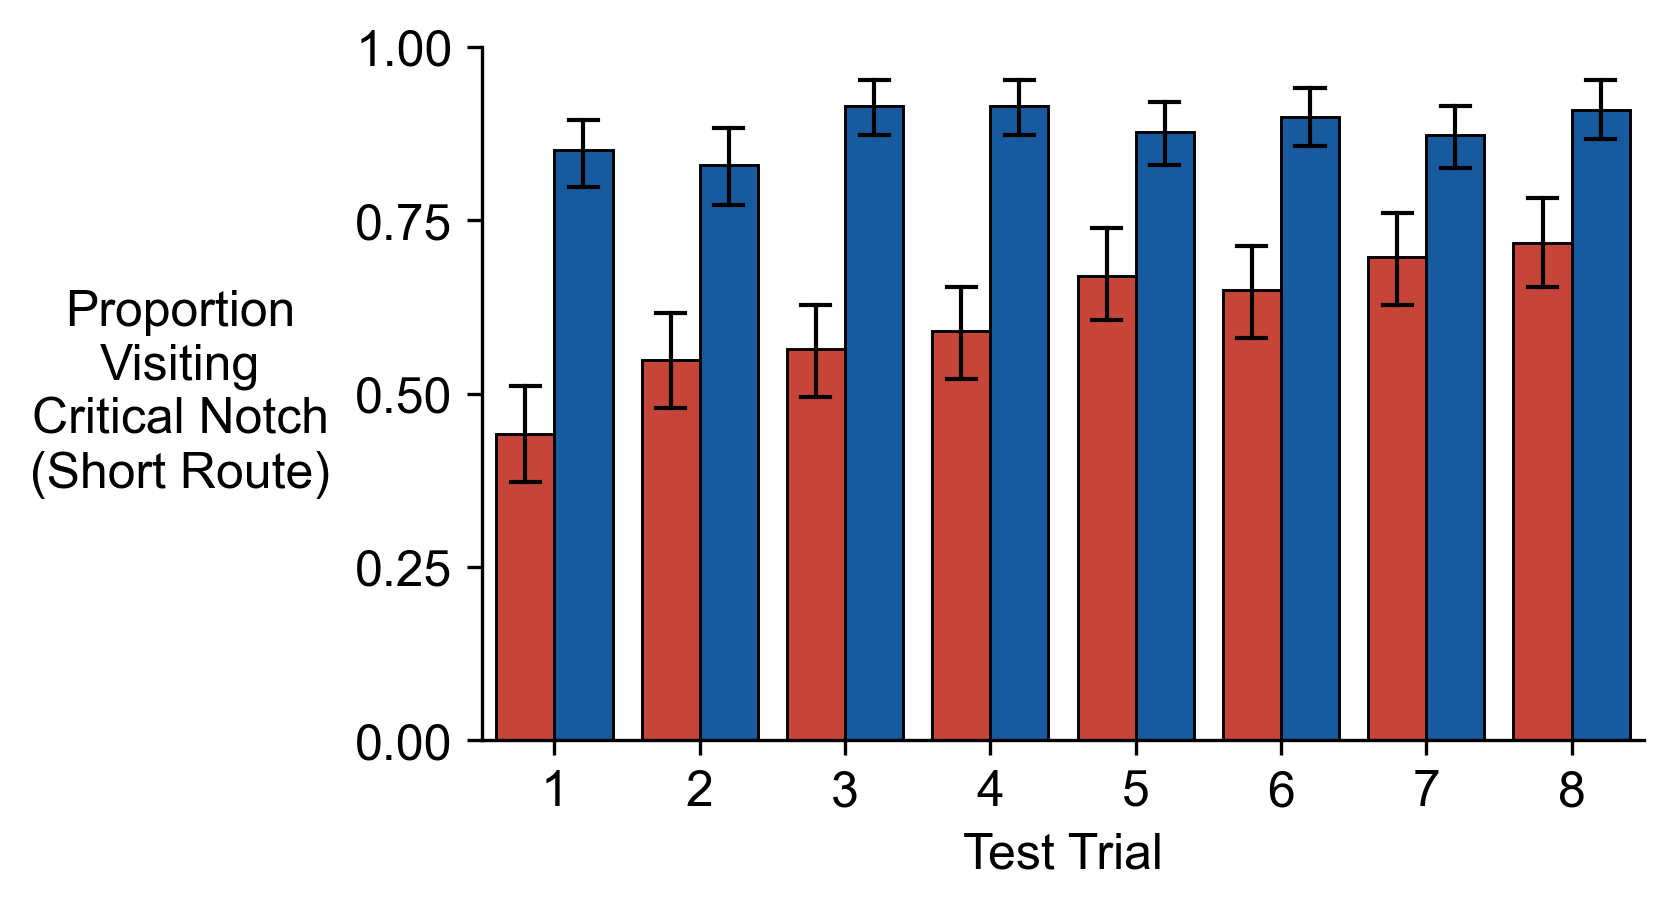

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
g = sns.barplot(
    ax=ax,
    data=test_trials,
    x='test_trial_num',
    y='visited_critical_notch',
    hue='condition_name',
    hue_order=['cccccccccccc', 'ffffffffffff'],
    palette=["#DC3220", "#005AB5"],
    errwidth=1.,
    edgecolor='k',
    linewidth=.7,
    capsize=.2,
    errcolor='k',
    errorbar=('ci', 95)
)
g.set_ylim(0, 1.0)
g.set_yticks([0, .25, .5, .75, 1.0])
plt.legend(
    bbox_to_anchor=(-.1, 1.35),
    loc=2,
    borderaxespad=0.,
    fancybox=False,
    framealpha=1,
    ncol=2
)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.get_legend().remove()
# g.legend_.set_title("Training Condition")
# for t, l in zip(g.legend_.texts, ["Notch Unnecessary", "Notch Necessary"]):
#     t.set_text(l)
ax.set_ylabel(
    "Proportion\nVisiting\nCritical Notch\n(Short Route)",
    rotation="horizontal",
    labelpad=42,
    va='center'
)
ax.set_xlabel("Test Trial")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set_xticklabels(["1", "2", "3", "4", "5", '6', '7', '8'])
# plt.savefig('./figures/exp1_notch_visit_plot.pdf', bbox_inches = "tight")

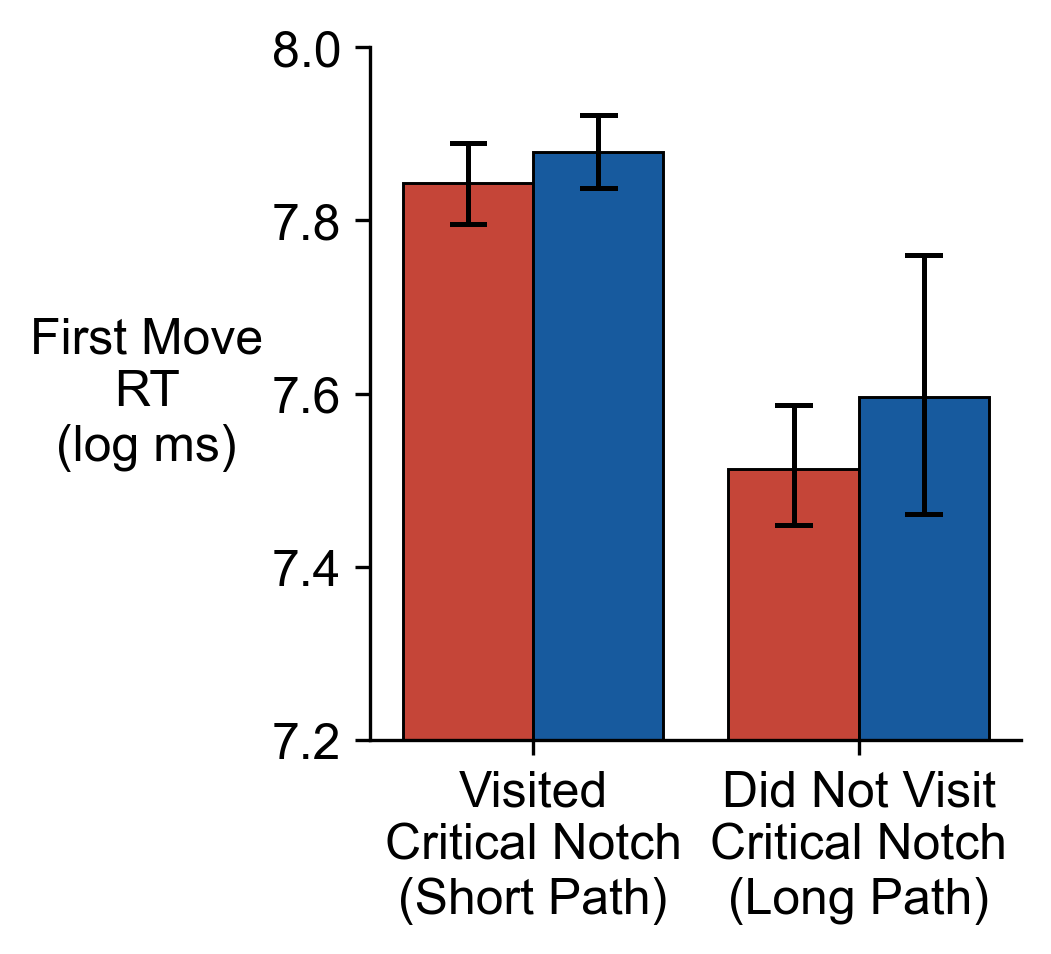

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 3), dpi=300)
sns.barplot(
    data=test_trials,
    y='log_initial_rt_milliseconds',
    x='visited_critical_notch',
    hue='condition_name',
    palette={'ffffffffffff': '#005AB5', 'cccccccccccc': "#DC3220"},
    errorbar=('ci', 95),
    errwidth=1.2,
    edgecolor='k',
    linewidth=.7,
    capsize=.1,
    errcolor='k',
    hue_order=['cccccccccccc', 'ffffffffffff', ],
    order=[True, False],
    ax=ax
)
ax.set_ylim(7.2, 8)
legend = ax.get_legend()
legend.remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(
    "First Move\nRT\n(log ms)",
    rotation="horizontal",
    labelpad=30,
    va='center'
)
ax.set_xlabel(None)
ax.set_xticklabels([
    {'True': 'Visited\nCritical Notch\n(Short Path)', 'False': 'Did Not Visit\nCritical Notch\n(Long Path)'}[t.get_text()]
    for t in ax.get_xticklabels()
])
_ = ax.set_yticks([7.2, 7.4, 7.6, 7.8, 8])
# plt.savefig('./figures/exp1_init_rt_plot_2.pdf', bbox_inches = "tight")

/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  from ipykernel import kernelapp as app


Text(0.5, 0, 'Test Trial Number')

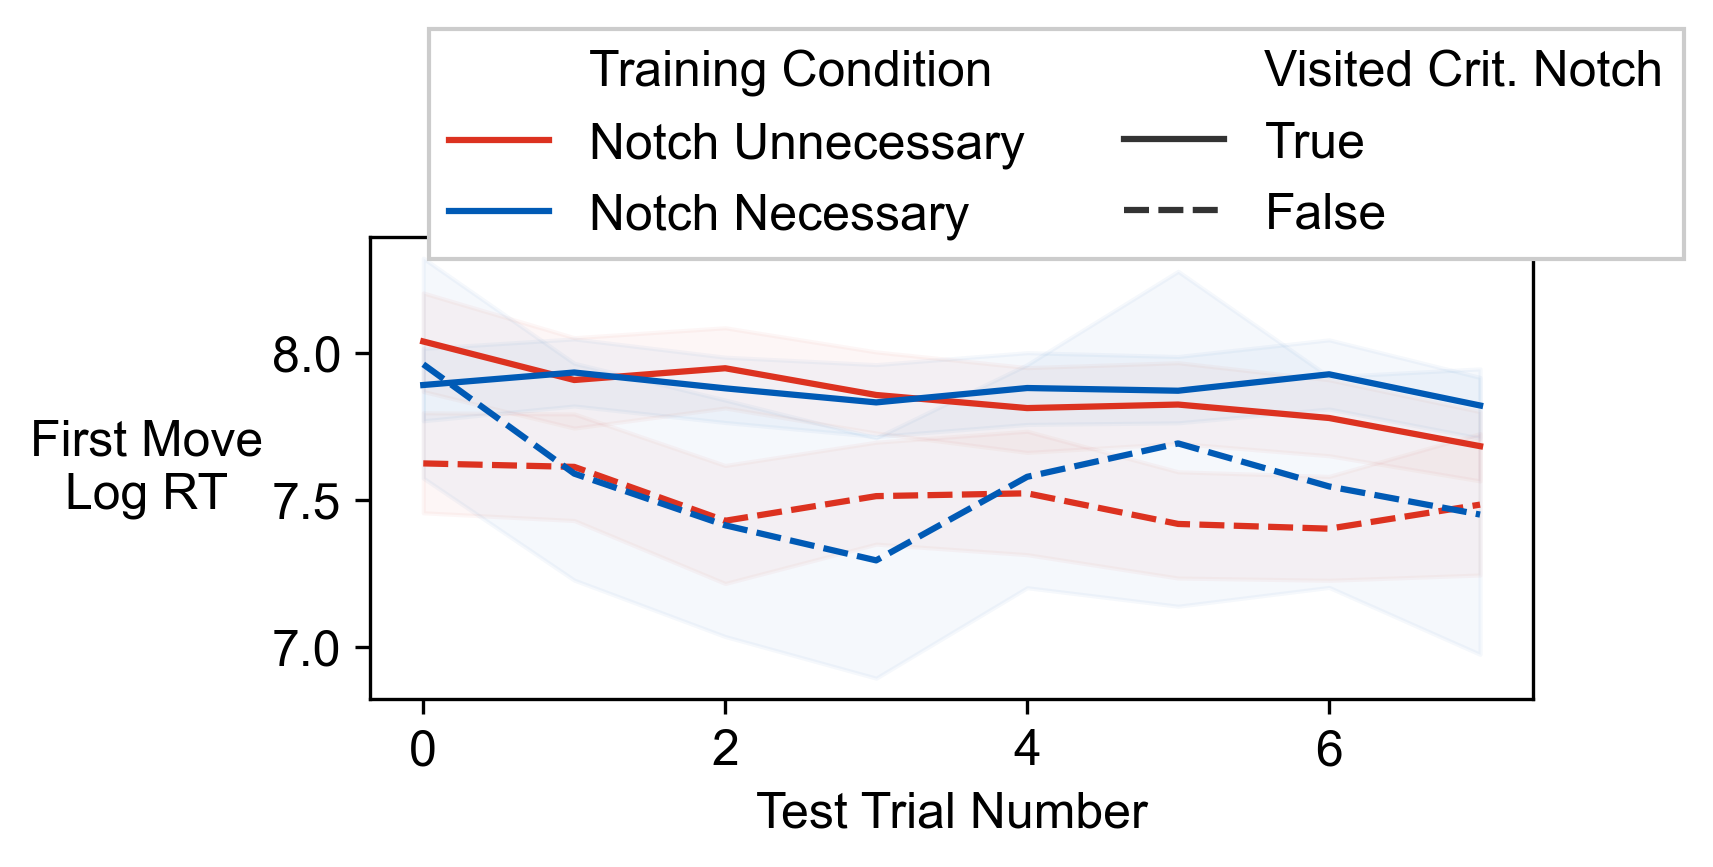

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=300)
g = sns.lineplot(
    ax=ax,
    data=test_trials,
    x='test_trial_num',
    y='log_initial_rt_milliseconds',
    hue='condition_name',
    style="visited_critical_notch",
    hue_order=['cccccccccccc', 'ffffffffffff'],
    palette=["#DC3220", "#005AB5"],
    style_order=[True, False],
    err_kws=dict(
        alpha=.04
    ),
    ci=95
)
plt.legend(
    bbox_to_anchor=(.05, 1.45),
    loc=2,
    borderaxespad=0.,
    fancybox=False,
    framealpha=1,
    ncol=2
)
for t, l in zip(g.legend_.texts, 
                ["Training Condition", "Notch Unnecessary", "Notch Necessary"] +
                ["Visited Crit. Notch", "True", "False"]
               ):
    t.set_text(l)
ax.set_ylabel(
    "First Move\nLog RT",
    rotation="horizontal",
    labelpad=30,
    va='center'
)
ax.set_xlabel("Test Trial Number")

# plt.savefig('./figures/exp1_init_rt_plot.pdf', bbox_inches = "tight")